In [1]:
# import basic libraries
import os
import numpy as np
import pandas as pd
import re
import random
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import pickle
import unicodedata
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter
import plotly.io as pio
#import pyperclip
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
import json
import unicodedata
import duckdb


In [2]:
conn = duckdb.connect('/srv/data/greek/grela.duckdb', read_only=True)

In [3]:
enemy_annotations = pd.read_csv("../data/enemy-annotations - sentences.csv")
enemy_annotations.head(5)

,Unnamed: 0,sentence_id,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,date_random,token_count,text,polemical category,notes
0,4,lagt_tlg4090.tlg001_8695,lagt,lagt_tlg4090.tlg001,Cyril of Alexandria,In XII Prophetas,412.0,444.0,['Theologici'],[],christian,425.0,482822,εἶτα δέον πάντας τούς ἐξ Ἰσραήλ ἐχθρούς ἡγεῖσθ...,1,"against Jews, δυσσεβείας"
1,5,lagt_tlg4090.tlg001_38952,lagt,lagt_tlg4090.tlg001,Cyril of Alexandria,In XII Prophetas,412.0,444.0,['Theologici'],[],christian,425.0,482822,μέθῃ δή οὖν καί σκότῳ καταληφθήσεσθαί φησι τού...,1,NaN
2,19,lagt_tlg4090.tlg001_60254,lagt,lagt_tlg4090.tlg001,Cyril of Alexandria,In XII Prophetas,412.0,444.0,['Theologici'],[],christian,425.0,482822,. . . . αὐτό . . αὐτῶ . τοαυτό . . πεφρασμένον...,1,NaN
3,29,lagt_tlg0317.tlg001_2231,lagt,lagt_tlg0317.tlg001,Acta Joannis,Acta Joannis,101.0,200.0,[],[],christian,180.0,23640,ὑμέρας ‖ μέρος ‖ ἤ ‖ ἐν παῤ αἰτῶ Δ ἀλλά πυρί α...,1,NaN
4,41,lagt_tlg2035.tlg131_764,lagt,lagt_tlg2035.tlg131,Athanasius,Oratio II contra Arianos,330.0,373.0,['Theologici'],[],christian,358.0,37973,ἕως ἄν . .( .) . θῶ τούς ἐχθρούς σου ὑποπόδιον...,1,NaN


In [29]:
# Python
enemy_annotations["polemical_category_first"] = (
    enemy_annotations["polemical category"]
    .apply(lambda x: x[0] if isinstance(x, str) and len(x) > 0 else None)
)

In [ ]:
# add tokens data to annotated sentences
conn.register("enemy_annotations", enemy_annotations)

enemy_annotations = conn.execute("""
SELECT ea.*,
       COALESCE(st.tokens, []) AS tokens
FROM enemy_annotations ea
LEFT JOIN (
  SELECT
    t.sentence_id,
    LIST(
      STRUCT_PACK(
        token_id    := t.token_id,
        token_text  := t.token_text,
        lemma       := t.lemma,
        pos         := t.pos,
        char_start  := t.char_start,
        char_end    := t.char_end,
        sentence_id := t.sentence_id
      )
      ORDER BY t.token_id
    ) AS tokens
  FROM tokens t
  SEMI JOIN enemy_annotations ea USING (sentence_id)
  GROUP BY t.sentence_id
) st USING (sentence_id)
""").df()

In [5]:
enemy_annotations.head(5)

,Unnamed: 0,sentence_id,grela_source,grela_id,author,title,not_before,not_after,lagt_tlg_epithet,lagt_genre,lagt_provenience,date_random,token_count,text,polemical category,notes,tokens
0,104,lagt_tlg2042.tlg058_10803,lagt,lagt_tlg2042.tlg058,Origen,Selecta in Psalmos [Dub.],208.0,220.0,['Theologici'],[],christian,210.0,129819,Καί ἐταράχθην ἀπό φωνῆς ἐχθροῦ καί ἀπό θλίψεως...,1,None,"[{'token_id': 163720546, 'token_text': 'Καί', ..."
1,571,lagt_tlg0061.tlg003_347,lagt,lagt_tlg0061.tlg003,Pseudo-Lucian,Δημοσθένους Ἐγκώμιον,201.0,300.0,['Sophistae'],[],pagan,208.0,5963,οὐκ ἐχθρῶν ἡμῖν ἔχθιστος ὁ Δημοσθένης;,None,None,"[{'token_id': 152488913, 'token_text': 'οὐκ', ..."
2,489,lagt_tlg2042.tlg058_14157,lagt,lagt_tlg2042.tlg058,Origen,Selecta in Psalmos [Dub.],208.0,220.0,['Theologici'],[],christian,210.0,129819,ἅρα τούς ἐχθρούς αὐτοῦ οὐκ ὠφέλησεν ὁ Χριστός.,1,need context,"[{'token_id': 163741161, 'token_text': 'ἅρα', ..."
3,702,lagt_tlg2200.tlg00431_86,lagt,lagt_tlg2200.tlg00431,Libanius,Oratio 31,387.0,387.0,['Rhetorici' 'Sophistae'],[],pagan,387.0,5508,) διά ἐχθρῶν Ρ ἐχθροῖς δειλαίνοντες δ᾿ ἐλαύνον...,5,None,"[{'token_id': 145486690, 'token_text': ')', 'l..."
4,263,lagt_tlg2018.tlg020_667,lagt,lagt_tlg2018.tlg020,Eusebius,Vita Constantini,325.0,339.0,['Scriptores Ecclesiastici' 'Theologici'],[],christian,336.0,53384,"τον, εἰσαεί νικῶντα τροπαίοις τε τοῖς κατ᾿ ἐχθ...",5,None,"[{'token_id': 145514225, 'token_text': 'τον', ..."


In [6]:
with open ("/srv/data/enemy-christ/large-data/grouped_df.pkl", "rb") as f:
    grouped = pickle.load(f)

/tmp/ipykernel_3989005/57775235.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  grouped = pickle.load(f)


In [7]:
grouped["tokens"][0]

'[{"lemma": "πινυτός", "token": "Πινυτός", "pos": "n", "char_start": 2, "char_end": 9}, {"lemma": "ἀντιγράφω", "token": "ἀντιγράφων", "pos": "v", "char_start": 10, "char_end": 20}]'

In [8]:
grouped["sentence_text"][0]

'ὁ Πινυτός ἀντιγράφων,'

In [9]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("pranaydeeps/Ancient-Greek-BERT")
model = AutoModel.from_pretrained("pranaydeeps/Ancient-Greek-BERT")

/srv/venvs/greek_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
sent = enemy_annotations["text"][1]
sent

'οὐκ ἐχθρῶν ἡμῖν ἔχθιστος ὁ Δημοσθένης;'

In [11]:
input_ids = tokenizer.encode(sent)
tokens = tokenizer.convert_ids_to_tokens(input_ids)
print(tokens)

['[CLS]', 'ουκ', 'εχθρων', 'ημι', '##ν', 'εχ', '##θι', '##στος', 'ο', 'δημοσθενη', '##ς', ';', '[SEP]']


In [34]:
import torch
import numpy as np
import inspect
from collections import defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"


# --------------------------------------------------------------
# Helper: Encode with safe truncation and proper device
# --------------------------------------------------------------
def encode_trunc(text: str, tokenizer, device="cpu", max_len=512):
    kwargs = {
        "text": text,
        "return_tensors": "pt",
        "truncation": True,
        "max_length": max_len,
    }
    # Preserve your check for optional arg
    sig = inspect.signature(tokenizer.__call__)
    if "add_special_tokens" in sig.parameters:
        kwargs["add_special_tokens"] = True

    enc = tokenizer(**kwargs)
    # Force-move every tensor to the right device
    for k, v in enc.items():
        if isinstance(v, torch.Tensor):
            enc[k] = v.to(device)
    return enc


# --------------------------------------------------------------
# Augmentation with subwords
# --------------------------------------------------------------
def augment_with_subwords(
    tokens: list[dict],
    *,
    tokenizer,
    anchor_use_lemma: bool,
    target_lemma: str
):
    target_lemma = target_lemma.lower()
    aug_tokens = []
    words = []
    sp_tokens = []
    sp_pos = 0

    prepend = tokenizer.cls_token or "<s>"
    append = tokenizer.sep_token or "</s>"
    if prepend:
        sp_tokens.append(prepend)
        sp_pos += 1

    for t in tokens:
        is_anchor = t["lemma"].lower() == target_lemma
        word = t["lemma"].lower() if is_anchor and anchor_use_lemma else t["token_text"].lower()

        try:
            word_ids = tokenizer(word, add_special_tokens=False)["input_ids"]
        except Exception:
            word_ids = tokenizer.encode(word, add_special_tokens=False)

        subwords = tokenizer.convert_ids_to_tokens(word_ids)

        new_t = dict(t)
        new_t["sp_first"] = sp_pos
        new_t["sp_pieces"] = subwords
        aug_tokens.append(new_t)

        words.append(word)
        sp_tokens.extend(subwords)
        sp_pos += len(subwords)

    if append:
        sp_tokens.append(append)

    sent_str = " ".join(words)
    return sent_str, sp_tokens, aug_tokens


# --------------------------------------------------------------
# Hidden-state embedding from model (average last 4 layers 8,9,10,11)
# --------------------------------------------------------------
def hidden_anchor_embedding(
    aug_tokens: list[dict],
    sent_str: str,
    *,
    tokenizer,
    model,
    device,
    target_lemma: str,
    layers: list[int] = (8, 9, 10, 11),  # layers to average
    piece_pooling: str = "mean",          # "mean" or "sum"
):
    target_lemma = target_lemma.lower()
    anchor = next((t for t in aug_tokens if t["lemma"].lower() == target_lemma), None)
    if anchor is None:
        return np.zeros(model.config.hidden_size, dtype=np.float32)

    sp_first = anchor["sp_first"]
    k = len(anchor["sp_pieces"])

    enc = encode_trunc(
        sent_str,
        tokenizer=tokenizer,
        device=device,
        max_len=tokenizer.model_max_length,
    )

    with torch.no_grad():
        outs = model(**enc, output_hidden_states=True)
        # outs.hidden_states is a tuple of length num_layers+1 if embeddings are included, or num_layers otherwise.
        # We index the desired transformer layers and average them.
        try:
            per_layer = [outs.hidden_states[i].squeeze(0) for i in layers]  # each [seq_len, dim]
        except IndexError:
            # If a requested layer index is out of range, fall back to the last available 4 layers
            num_hs = len(outs.hidden_states)
            fallback = list(range(max(0, num_hs - 4), num_hs))
            per_layer = [outs.hidden_states[i].squeeze(0) for i in fallback]

        hidden = torch.stack(per_layer, dim=0).mean(dim=0)  # [seq_len, dim]

    if sp_first + k - 1 >= hidden.shape[0]:
        return np.zeros(model.config.hidden_size, dtype=np.float32)

    span = hidden[sp_first : sp_first + k]  # [k, dim]
    vec = span.sum(dim=0) if piece_pooling == "sum" else span.mean(dim=0)
    return vec.detach().cpu().numpy()


# --------------------------------------------------------------
# Attention-based weighting of lemmas
# --------------------------------------------------------------
def attention_weights_by_lemma(
    aug_tokens: list[dict],
    sent_str: str,
    *,
    tokenizer,
    model,
    device,
    att_layer: int,
    target_lemma: str,
    top_k: int = 3,           # number of top attention heads to keep
    direction: str = "from",  # "from" = target attends to others, "to" = others attend to target
    normalize: bool = True,   # normalize anchor_vec to sum to 1
):
    target_lemma = target_lemma.lower()

    enc = encode_trunc(
        sent_str,
        tokenizer=tokenizer,
        device=device,
        max_len=tokenizer.model_max_length,
    )

    with torch.no_grad():
        outs = model(**enc, output_attentions=True)
        A_heads = outs.attentions[att_layer][0].cpu()  # [num_heads, L, L]

    anchor = next((t for t in aug_tokens if t["lemma"].lower() == target_lemma), None)
    if anchor is None:
        return {}

    sp_first = anchor["sp_first"]
    k_anchor = len(anchor["sp_pieces"])
    L = A_heads.shape[-1]

    if sp_first + k_anchor - 1 >= L:
        return {}

    if direction == "from":
        per_head_anchor_vecs = A_heads[:, sp_first : sp_first + k_anchor, :].mean(dim=1)
    elif direction == "to":
        per_head_anchor_vecs = A_heads[:, :, sp_first : sp_first + k_anchor].mean(dim=2)
    else:
        raise ValueError("direction must be 'from' or 'to'")

    head_scores = per_head_anchor_vecs.sum(dim=1)  # [H]
    top_head_ids = torch.topk(head_scores, k=top_k).indices
    anchor_vec = per_head_anchor_vecs[top_head_ids].mean(dim=0)  # [L]

    if normalize and anchor_vec.sum() > 0:
        anchor_vec = anchor_vec / anchor_vec.sum()

    lemma_info = defaultdict(lambda: {"weight": 0.0, "pieces": []})
    for t in aug_tokens:
        lemma = t["lemma"].lower()
        if lemma == target_lemma or lemma.strip() == "":
            continue

        start = t["sp_first"]
        end = start + len(t["sp_pieces"])
        if end > anchor_vec.shape[0]:
            continue

        total_w = anchor_vec[start:end].sum().item()
        lemma_info[lemma]["weight"] += total_w

        for j, piece in enumerate(t["sp_pieces"]):
            idx = start + j
            lemma_info[lemma]["pieces"].append({
                "piece": piece,
                "sp_idx": idx,
                "weight": float(anchor_vec[idx]),
            })

    return dict(lemma_info)

In [13]:
tokens = enemy_annotations["tokens"].tolist()[1]

In [14]:
sent_str, sp_tokens, aug_tokens = augment_with_subwords(
    tokens,
    tokenizer=tokenizer,
    anchor_use_lemma=True,      # or False, per your design
    target_lemma="ἐχθρός",      # example
)

In [15]:
aug_tokens

[{'token_id': 152488913,
  'token_text': 'οὐκ',
  'lemma': 'οὐ',
  'pos': 'r',
  'char_start': 0,
  'char_end': 3,
  'sentence_id': 'lagt_tlg0061.tlg003_347',
  'sp_first': 1,
  'sp_pieces': ['ουκ']},
 {'token_id': 152488914,
  'token_text': 'ἐχθρῶν',
  'lemma': 'ἐχθρός',
  'pos': 'a',
  'char_start': 4,
  'char_end': 10,
  'sentence_id': 'lagt_tlg0061.tlg003_347',
  'sp_first': 2,
  'sp_pieces': ['εχθρος']},
 {'token_id': 152488915,
  'token_text': 'ἡμῖν',
  'lemma': 'ἡμεῖς',
  'pos': 'p',
  'char_start': 11,
  'char_end': 15,
  'sentence_id': 'lagt_tlg0061.tlg003_347',
  'sp_first': 3,
  'sp_pieces': ['ημι', '##ν']},
 {'token_id': 152488916,
  'token_text': 'ἔχθιστος',
  'lemma': 'ἔχθιστος',
  'pos': 'a',
  'char_start': 16,
  'char_end': 24,
  'sentence_id': 'lagt_tlg0061.tlg003_347',
  'sp_first': 5,
  'sp_pieces': ['εχ', '##θι', '##στος']},
 {'token_id': 152488917,
  'token_text': 'ὁ',
  'lemma': 'ὁ',
  'pos': 'l',
  'char_start': 25,
  'char_end': 26,
  'sentence_id': 'lagt_tlg00

In [21]:
# 1) Build a Series of 3-tuples (sent_str, sp_tokens, aug_tokens)
out = enemy_annotations["tokens"].apply(
    lambda toks: augment_with_subwords(
        toks,
        tokenizer=tokenizer,
        anchor_use_lemma=True,
        target_lemma="ἐχθρός",
    )
)

# 2) Unzip into three new columns
enemy_annotations["sent_str"], enemy_annotations["sp_tokens"], enemy_annotations["aug_tokens"] = zip(*out)

In [36]:
# compute vectors row-wise
enemy_annotations["enemy_emb"] = enemy_annotations.apply(
    lambda row: hidden_anchor_embedding(
        row["aug_tokens"],
        row["sent_str"],
        tokenizer=tokenizer,
        model=model,
        device="cpu",       # "cpu" or "cuda"
        target_lemma="ἐχθρός",
        piece_pooling="mean",
    ),
    axis=1
)

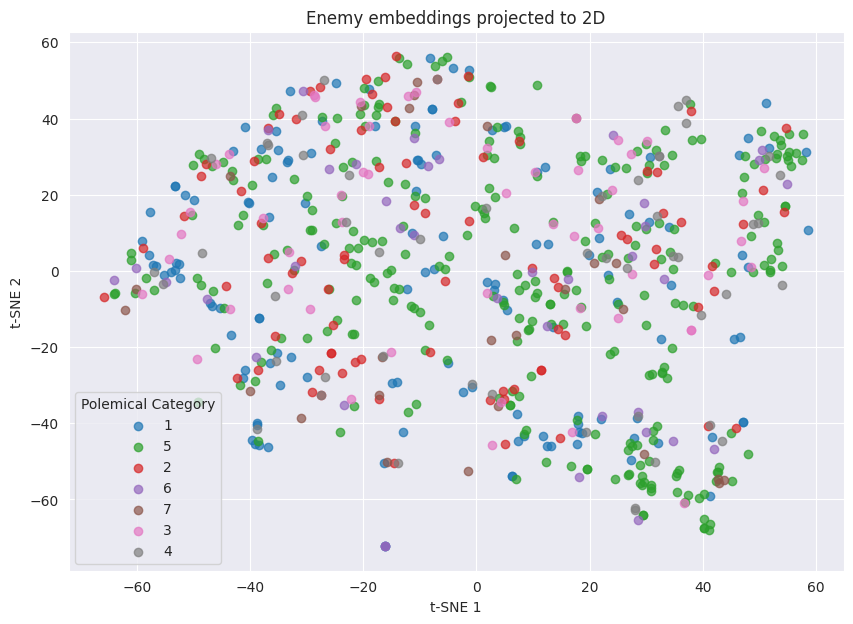

In [37]:
# 1) Stack your embeddings into a 2D array
X = np.stack(enemy_annotations["enemy_emb"].to_numpy())  # shape (n, hidden_size)

# 2) Dimensionality reduction (to 2D)
tsne = TSNE(n_components=2, random_state=42, init="random", learning_rate="auto", perplexity=10)
X_2d = tsne.fit_transform(X)

# 3) Add to your DataFrame for convenience
enemy_annotations["x"] = X_2d[:,0]
enemy_annotations["y"] = X_2d[:,1]

# 4) Scatter plot, coloring by "polemical category"
plt.figure(figsize=(10,7))
categories = enemy_annotations["polemical_category_first"].unique()

for cat in categories:
    subset = enemy_annotations[enemy_annotations["polemical_category_first"] == cat]
    plt.scatter(subset["x"], subset["y"], label=cat, alpha=0.7)

plt.legend(title="Polemical Category")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Enemy embeddings projected to 2D")
plt.show()